In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
# read keypoints
cas = cv2.CascadeClassifier('./model/haarcascade_frontalface_alt2.xml')
obj = cv2.face.createFacemarkLBF()
obj.loadModel('./model/lbfmodel.yaml')
def detect_facepoint(img):
    img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    print(img_gray.shape)
    print(cas.detectMultiScale(img_gray,2,3,0,(30,30)))
    faces = cas.detectMultiScale(img_gray,2,3,0,(30,30))
    landmarks = obj.fit(img_gray,faces)
    assert landmarks[0],'no face detected'
    if(len(landmarks[1])>1):
        print('multi face detected,use the first')
    kps = np.squeeze(landmarks[1][0])
    points=[]
    for i in range(kps.shape[0]):
        points.append((int(kps[i,0]),int(kps[i,1])))
    return points


In [3]:
# Apply affine transform calculated using srcTri and dstTri to src and
# output an image of size.
def applyAffineTransform(src, srcTri, dstTri, size) :
    
    # Given a pair of triangles, find the affine transform.
    warpMat = cv2.getAffineTransform( np.float32(srcTri), np.float32(dstTri) )
    
    # Apply the Affine Transform just found to the src image
    dst = cv2.warpAffine( src, warpMat, (size[0], size[1]), None, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101 )

    return dst


# Check if a point is inside a rectangle
def rectContains(rect, point) :
    if point[0] < rect[0] :
        return False
    elif point[1] < rect[1] :
        return False
    elif point[0] > rect[0] + rect[2] :
        return False
    elif point[1] > rect[1] + rect[3] :
        return False
    return True


#calculate delanauy triangle
def calculateDelaunayTriangles(rect, points):
    #create subdiv
    subdiv = cv2.Subdiv2D(rect);
    
    # Insert points into subdiv
    for p in points:
        subdiv.insert(p) 
    
    triangleList = subdiv.getTriangleList();
    
    delaunayTri = []
    
    pt = []    
        
    for t in triangleList:        
        pt.append((t[0], t[1]))
        pt.append((t[2], t[3]))
        pt.append((t[4], t[5]))
        
        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])        
        
        if rectContains(rect, pt1) and rectContains(rect, pt2) and rectContains(rect, pt3):
            ind = []
            #Get face-points (from 68 face detector) by coordinates
            for j in range(0, 3):
                for k in range(0, len(points)):                    
                    if(abs(pt[j][0] - points[k][0]) < 1.0 and abs(pt[j][1] - points[k][1]) < 1.0):
                        ind.append(k)    
            # Three points form a triangle. Triangle array corresponds to the file tri.txt in FaceMorph 
            if len(ind) == 3:                                                
                delaunayTri.append((ind[0], ind[1], ind[2]))
        
        pt = []        
            
    
    return delaunayTri

In [4]:
# Warps and alpha blends triangular regions from img1 and img2 to img
def warpTriangle(img1, img2, t1, t2) :

    # Find bounding rectangle for each triangle
    r1 = cv2.boundingRect(np.float32([t1]))
    r2 = cv2.boundingRect(np.float32([t2]))

    # Offset points by left top corner of the respective rectangles
    t1Rect = [] 
    t2Rect = []
    t2RectInt = []

    for i in range(0, 3):
        t1Rect.append(((t1[i][0] - r1[0]),(t1[i][1] - r1[1])))
        t2Rect.append(((t2[i][0] - r2[0]),(t2[i][1] - r2[1])))
        t2RectInt.append(((t2[i][0] - r2[0]),(t2[i][1] - r2[1])))


    # Get mask by filling triangle
    mask = np.zeros((r2[3], r2[2], 3), dtype = np.float32)
    cv2.fillConvexPoly(mask, np.int32(t2RectInt), (1.0, 1.0, 1.0), 16, 0);

    # Apply warpImage to small rectangular patches
    img1Rect = img1[r1[1]:r1[1] + r1[3], r1[0]:r1[0] + r1[2]]
    #img2Rect = np.zeros((r2[3], r2[2]), dtype = img1Rect.dtype)
    
    size = (r2[2], r2[3])

    img2Rect = applyAffineTransform(img1Rect, t1Rect, t2Rect, size)
    
    img2Rect = img2Rect * mask

    # Copy triangular region of the rectangular patch to the output image
    img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] * ( (1.0, 1.0, 1.0) - mask )
     
    img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] + img2Rect 
    
    return img2Rect[:,:,::-1]


In [5]:
 # Read images
filename1 = './images/zly.jpg'
filename2 = './images/hjh.jpg'

img1 = cv2.imread(filename1);
img2 = cv2.imread(filename2);
img1Warped = np.copy(img2);    

In [6]:
points1=detect_facepoint(img1)
points2=detect_facepoint(img2)

(889, 500)
[[178 138 160 160]]
(540, 540)
[[173 146 160 160]]


In [7]:
# Find convex hull
hull1 = []
hull2 = []

hullIndex = cv2.convexHull(np.array(points2), returnPoints = False)

for i in range(0, len(hullIndex)):
    hull1.append(points1[int(hullIndex[i])])
    hull2.append(points2[int(hullIndex[i])])
 # Find delanauy traingulation for convex hull points
sizeImg2 = img2.shape    
rect = (0, 0, sizeImg2[1], sizeImg2[0])

dt = calculateDelaunayTriangles(rect, hull2)

In [8]:
dt

[(5, 12, 13),
 (12, 5, 11),
 (11, 5, 6),
 (0, 1, 21),
 (1, 2, 20),
 (2, 3, 20),
 (8, 10, 7),
 (10, 8, 9),
 (3, 4, 20),
 (7, 10, 6),
 (4, 5, 13),
 (6, 10, 11),
 (4, 13, 20),
 (20, 13, 14),
 (20, 14, 15),
 (20, 15, 19),
 (17, 19, 16),
 (19, 17, 18),
 (16, 19, 15),
 (1, 20, 21)]

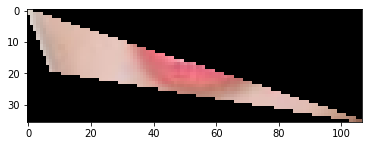

In [9]:
if len(dt) == 0:
    quit()
    
# Apply affine transformation to Delaunay triangles
# for i in range(0, len(dt)):
i=1
t1 = []
t2 = []

#get points for img1, img2 corresponding to the triangles
for j in range(0, 3):
    t1.append(hull1[dt[i][j]])
    t2.append(hull2[dt[i][j]])

plt.imshow(warpTriangle(img1, img1Warped, t1, t2)/255.0)

In [10]:
if len(dt) == 0:
    quit()

# Apply affine transformation to Delaunay triangles
for i in range(0, len(dt)):
    t1 = []
    t2 = []

    #get points for img1, img2 corresponding to the triangles
    for j in range(0, 3):
        t1.append(hull1[dt[i][j]])
        t2.append(hull2[dt[i][j]])

    warpTriangle(img1, img1Warped, t1, t2)

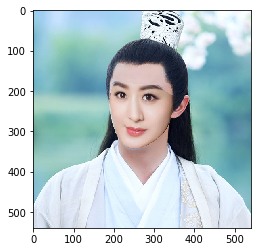

In [14]:
plt.imshow(cv2.cvtColor(img1Warped,cv2.COLOR_BGR2RGB))

In [11]:
# Calculate Mask
hull8U = []
for i in range(0, len(hull2)):
    hull8U.append((hull2[i][0], hull2[i][1]))

mask = np.zeros(img2.shape, dtype = img2.dtype)  

cv2.fillConvexPoly(mask, np.int32(hull8U), (255, 255, 255))

r = cv2.boundingRect(np.float32([hull2]))    

center = ((r[0]+int(r[2]/2), r[1]+int(r[3]/2)))

In [12]:
# Clone seamlessly.
output = cv2.seamlessClone(np.uint8(img1Warped), img2, mask, center, cv2.NORMAL_CLONE)

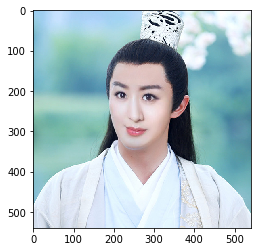

In [13]:
plt.imshow(cv2.cvtColor(output,cv2.COLOR_BGR2RGB))